## A scikit-learn compatible method for estimation of a good enough number of clusters with WCSS metric
I transformed my function for numeric application of Elbow method into scikit-learn Estimator object. It is called
`EstimatedClusterNumberWithWCSS`. Now you can  import it and initialize an object. The object contains a class which allows to run the method a few time to check how many cluster number estimations we can get. Due to the random nature of K-means we might get a few. I added this feature because I was recommended to implement a 
possibility to evaluate how reliable is estimated clustering. The object returns one number as a number of clusters which appeared with most frequency during fitting, and a dictionary of all computed cluster numbers with corresponding frequencies. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.datasets import make_blobs
import warnings
from sklearn.cluster import KMeans
from tqdm import trange
import EstimatedClusterNumberWithWCSS as ECNW

Let us define properties which will be the same for all considered clusters.

In [2]:
true_cluster_n = 6
points_per_cluster = 500
possible_cluster_n = 12

Here is a function to convert a  list of class numbers into list of colors, so they can used for plotting with 
`seaborn`.

In [3]:
def _6_colors(labels):
    # colors from colorbrewer2.org: 
    # ['#b2182b','#ef8a62','#fddbc7','#d1e5f0','#67a9cf','#2166ac']
    colors=['#b2182b']*len(labels)
    for i in range(len(labels)):
        if (labels[i] ==0):
            colors[i] = '#ef8a62'
        elif (labels[i]==1):
            colors[i] = '#fddbc7'
        elif (labels[i]==2):
            colors[i] = '#d1e5f0'
        elif (labels[i]==3):
            colors[i] = '#67a9cf'
        elif (labels[i]==4):
            colors[i] = '#2166ac'
        
    return(colors)

I would like to run my method a few times on numpy arrays generated by `scikit-learn` method `make_blobs` to show how it works. Each time we will have a distinct `random_state` to produce a set 6 blobs. We will see blob and cluster visualizations, what was chosen as recommended number and what other possible cluster number were calculated and how many times they appeared. If clustering does not appear to be sufficiently optimal for provided conditions we will see a warning message. 

My threshold to decide if an estimated number is good under our conditions is the following:
It appears in not less than in about 2/3 of cases. The threshold value is one of the method parameters and may be changed. Note that the message comes from the estimating number of clusters method, and it will appear before plots and results of clustering.

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

The most frequent value = 6
Frequency counts with random state = 0:
{6: 50}


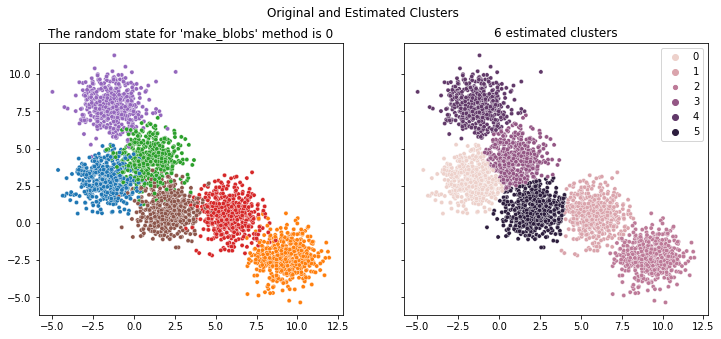

 12%|██████████▍                                                                        | 1/8 [07:51<54:57, 471.10s/it]

The most frequent value = 5
Frequency counts with random state = 1:
{5: 48, 12: 1, 6: 1}


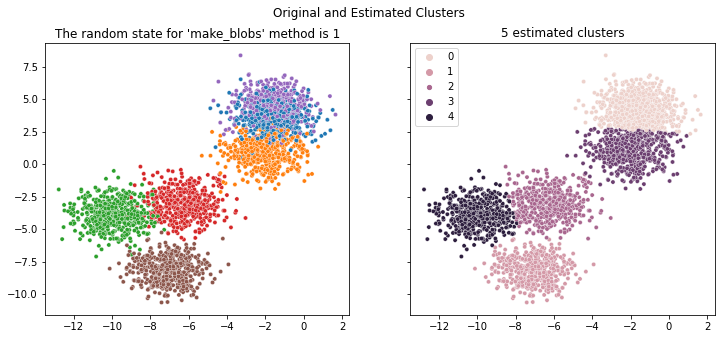

 25%|████████████████████▊                                                              | 2/8 [15:32<46:32, 465.34s/it]

The most frequent value = 6
Frequency counts with random state = 2:
{6: 47, 12: 2, 11: 1}


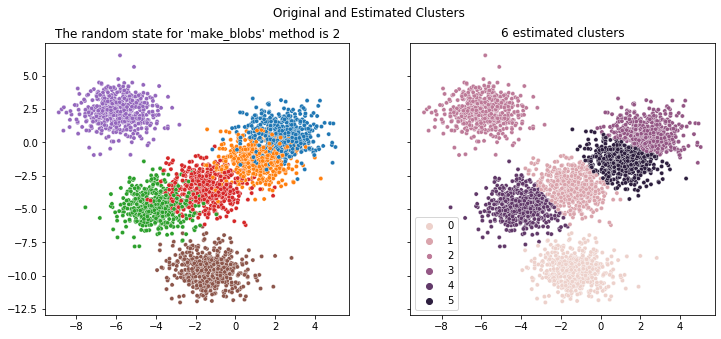

 38%|███████████████████████████████▏                                                   | 3/8 [23:23<39:00, 468.10s/it]


                      reliable result, although it can suffice for
                      your business/research objective. It might 
                      be improved with other parameters or methods.
The most frequent value = 11
Frequency counts with random state = 3:
{11: 29, 5: 14, 12: 4, 6: 3}


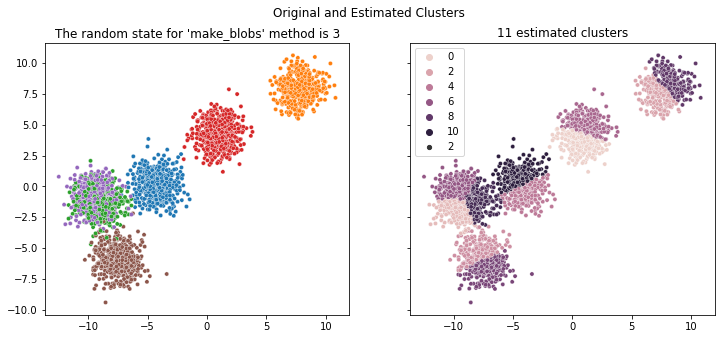

 50%|█████████████████████████████████████████▌                                         | 4/8 [30:31<30:08, 452.09s/it]

The most frequent value = 6
Frequency counts with random state = 4:
{6: 49, 10: 1}


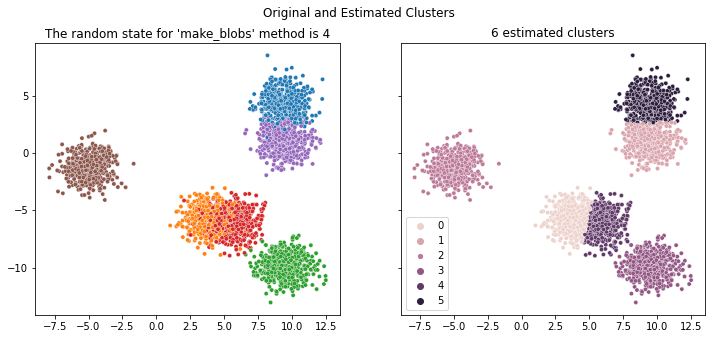

 62%|███████████████████████████████████████████████████▉                               | 5/8 [37:37<22:08, 442.70s/it]


                      reliable result, although it can suffice for
                      your business/research objective. It might 
                      be improved with other parameters or methods.
The most frequent value = 5
Frequency counts with random state = 5:
{5: 25, 11: 14, 6: 8, 10: 2, 12: 1}


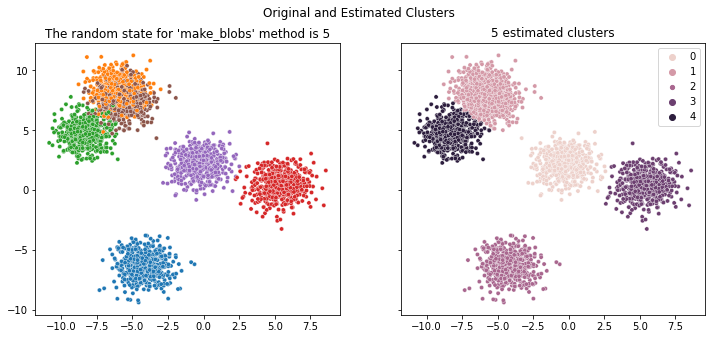

 75%|██████████████████████████████████████████████████████████████▎                    | 6/8 [44:53<14:40, 440.47s/it]

The most frequent value = 6
Frequency counts with random state = 6:
{6: 48, 12: 2}


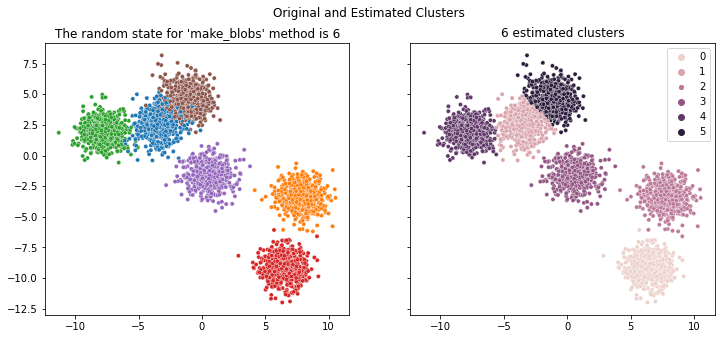

 88%|████████████████████████████████████████████████████████████████████████▋          | 7/8 [52:02<07:16, 436.57s/it]

The most frequent value = 6
Frequency counts with random state = 7:
{6: 49, 12: 1}


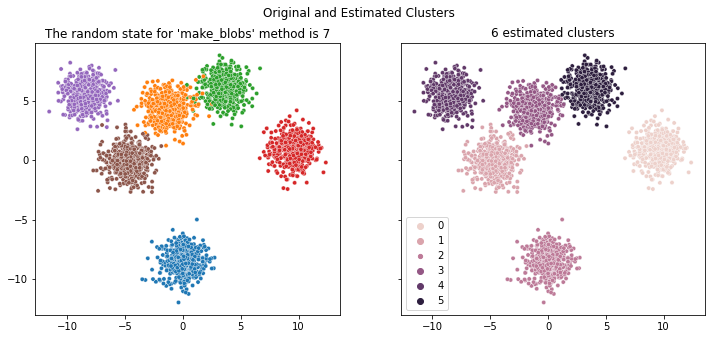

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [58:59<00:00, 442.43s/it]

Wall time: 58min 59s


In [4]:
%%time

true_cluster_n = 6
points_per_cluster = 500
possible_cluster_n = 12

for k in trange(8):
    random_state = k
    Y, y = make_blobs(n_samples=(points_per_cluster*true_cluster_n), 
                      centers= true_cluster_n, n_features=2, 
                      random_state=random_state)
    
    ecnw = ECNW.NumericElbowMethod(start=1, end=possible_cluster_n, 
                                   n_init=50, metric="elbow",
                                   random_state=random_state)
    ecnw.fit(array=Y)
    
    print("The most frequent value = " + str(ecnw.estimated_n_))
    print("Frequency counts with random state = " + str(k)+":")
    print(ecnw.cluster_frequencies_)
    
    warnings.filterwarnings("ignore")
    kmeans = KMeans(n_clusters = ecnw.estimated_n_, 
                                max_iter=300,init = 'k-means++', 
                                n_init=40)
    kmeans.fit(Y)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle('Original and Estimated Clusters')
    sb.scatterplot(ax=axes[0], x=Y[:, 0], y=Y[:, 1], legend=False,
                      hue=_6_colors(y), size = 2)
    axes[0].set_title("The random state for 'make_blobs' method is "+
                      str(random_state))
    
    sb.scatterplot(ax=axes[1], x=Y[:, 0], y=Y[:, 1], 
                      hue=kmeans.labels_, size = 2)
    axes[1].set_title(str(ecnw.estimated_n_) + " estimated clusters")
    plt.show()

As we see the method might discover problems when blobs merge together. This is the "within-cluster sums of squares" metric property: it favors compact clusters which contain about the same number of points.

Another interesting question is how the method will work if a set cannot be divided into obvious clusters. For example, when all point are uniformly distributed in a rectangle. I provided an example below.

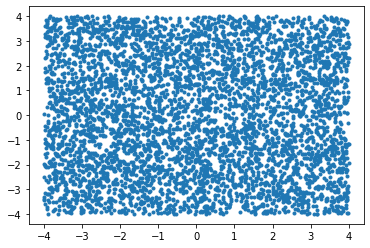


                      reliable result, although it can suffice for
                      your business/research objective. It might 
                      be improved with other parameters or methods.
The most frequent value = 26

Frequency counts:
{26: 23, 25: 22, 24: 18, 22: 14, 23: 14, 21: 8, 20: 1}


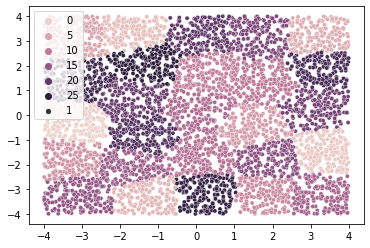

Wall time: 1h 16min 49s


In [5]:
%%time

xu = np.random.uniform(low=-4, high=4, size=5000)
yu = np.random.uniform(low=-4, high=4, size=5000)
data = np.column_stack([xu, yu])
plt.scatter(xu, yu, marker=".")
plt.show()

ecnw0 = ECNW.NumericElbowMethod(start=3, end=26, n_init=100)
ecnw0.fit(array=data)

print("The most frequent value = " + str(ecnw0.estimated_n_))
print("\nFrequency counts:")
print(ecnw0.cluster_frequencies_)
kmeans = KMeans(
        n_clusters=ecnw0.estimated_n_, max_iter=300, init="k-means++",
        n_init=40)
kmeans.fit(data)
sb.scatterplot(x=xu, y=yu, hue=kmeans.labels_, size=1)
plt.show()

I ran the above code several times and kept getting different estimations for a number of clusters and diverse shapes even for the same number of clusters.